## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

### Functions for drawing and calibration

In [2]:
def corner_img(images, nx, ny, objp):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_list = [] #ret detected image list
    drawn_list = []
    # Step through the list and search for chessboard corners
    for fname in images:    
        image = cv2.imread(fname)
        img = image.copy()
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points      
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img_list.append(image)
            # Draw and display the corners
            drawn_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            drawn_list.append(drawn_img)
    return objpoints, imgpoints, img_list, drawn_list


### Get the calibration parameters and save them as pickle (ganna take a while)

In [3]:
%%time
import pickle

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print('Total images: {}'.format(len(images)))

objpoints, imgpoints, img_list, drawn_list = corner_img(images, nx, ny, objp)

img_size = (img_list[0].shape[1], img_list[0].shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist.p", "wb" ) )


Total images: 20
Wall time: 10.4 s


### Calibrate images

In [8]:
undist_list = []

for img in img_list:
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_list.append(undist)


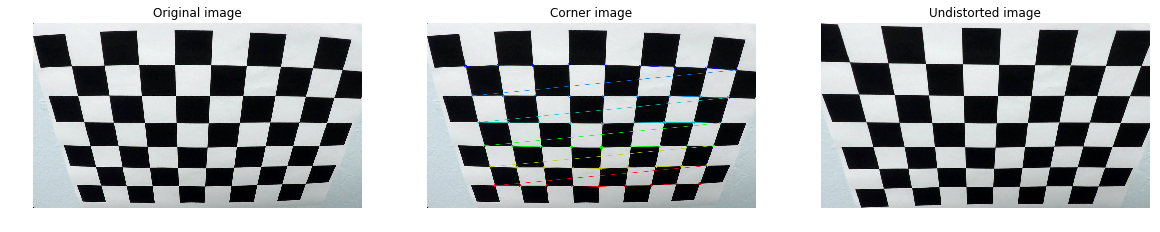

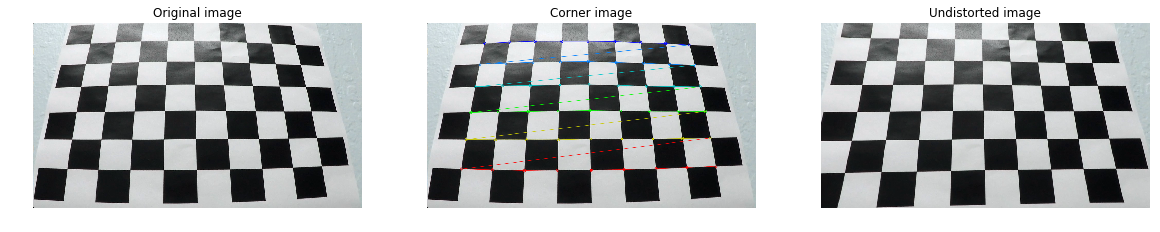

In [9]:
pltimg_list = [10, 12]

for i in pltimg_list:
    plt.figure(figsize=[20, 6])
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('Original image')
    plt.imshow(img_list[i])
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title('Corner image')
    plt.imshow(drawn_list[i])
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Undistorted image')
    plt.imshow(undist_list[i])
    plt.show()

## Lane Detection Pipeline

### Start from here since we already have the calibration parameters

In [1]:
import matplotlib.image as mpimg
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from lane_finding import *
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#camera_cal_dist_pickle
with open('camera_dist.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']

test_images = glob.glob('test_images/*.jpg')
print('Total images: {}'.format(len(test_images)))

Total images: 8


### Thresholded  Sobel x and y

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

### Thresholded gradient magnitude

In [3]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

### Thresholded gradient direction

In [4]:
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

### Visualizing thresholded sobel x and y

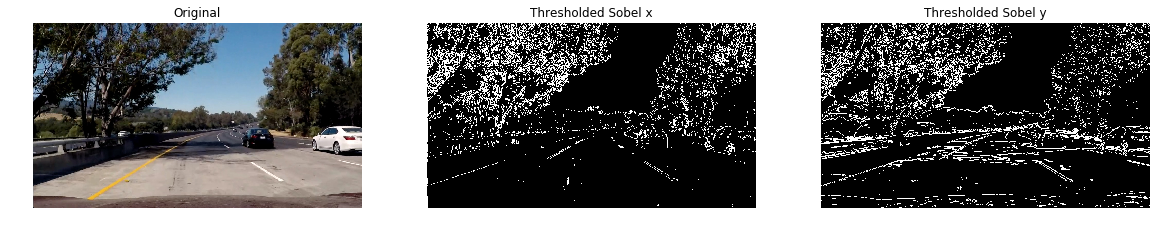

In [5]:
image = ('test_images/test5.jpg')

img = mpimg.imread(image)
grad_binary_x = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
grad_binary_y = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
plt.figure(figsize=[20, 5])
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original')
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Thresholded Sobel x')
plt.imshow(grad_binary_x, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Thresholded Sobel y')
plt.imshow(grad_binary_y, cmap='gray')
plt.show()

### Thresholded gradient magnitude and direction

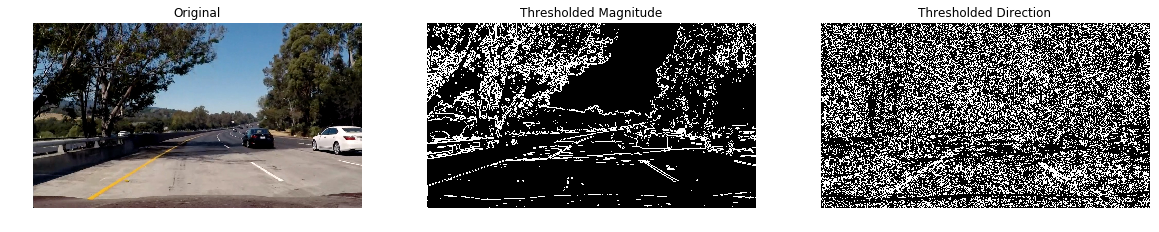

In [6]:
img = mpimg.imread(image)
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, dir_thresh=(0.7, 1.3))
plt.figure(figsize=[20, 5])
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original')
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Thresholded Magnitude')
plt.imshow(mag_binary, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Thresholded Direction')
plt.imshow(dir_binary, cmap='gray')
plt.show()

### Color threshold

In [7]:
def color_filter(image):
    # Filter white color
    white_thresh = [np.array([200, 200, 200]), np.array([255, 255, 255])]
    mask = cv2.inRange(image, white_thresh[0], white_thresh[1])
    white_img = cv2.bitwise_and(image, image, mask=mask)

    #Changing Color-space to HSV which is better for object detection
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].   
    yellow_thresh = [np.array([90,100,100]), np.array([110,255,255])]
    mask = cv2.inRange(hsv, yellow_thresh[0], yellow_thresh[1])
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    # Create binary based on detected pixels
    binary_threshold = np.zeros_like(gray)
    binary_threshold[(gray > 0)] = 1
    return white_img, yellow_img, binary_threshold

### Binary image after color filter

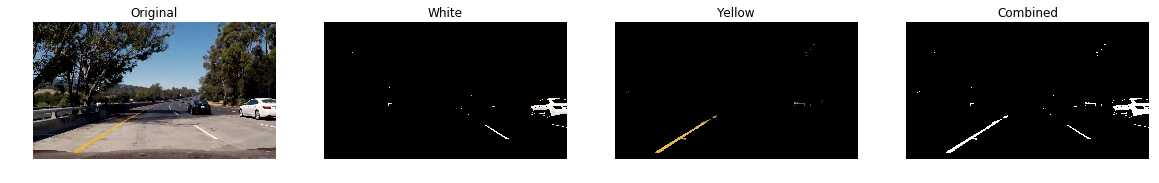

In [8]:
img = mpimg.imread(image)
white_img, yellow_img, binary_threshold = color_filter(img)
plt.figure(figsize=[20, 5])
plt.subplot(1, 4, 1)
plt.axis('off')
plt.title('Original')
plt.imshow(img)
plt.subplot(1, 4, 2)
plt.axis('off')
plt.title('White')
plt.imshow(white_img, cmap='gray')
plt.subplot(1, 4, 3)
plt.axis('off')
plt.title('Yellow')
plt.imshow(yellow_img, cmap='gray')
plt.subplot(1, 4, 4)
plt.axis('off')
plt.title('Combined')
plt.imshow(binary_threshold, cmap='gray')
plt.show()

### Getting source and destination points and perspective transform matrix

In [2]:
src = np.array([[581, 477], [699, 477], [896, 675], [384, 675]]).astype(np.float32)
dst = np.array([[384, 0], [896, 0], [896, 720], [384, 720]]).astype(np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

### Plot undistored and binary bird eye view image

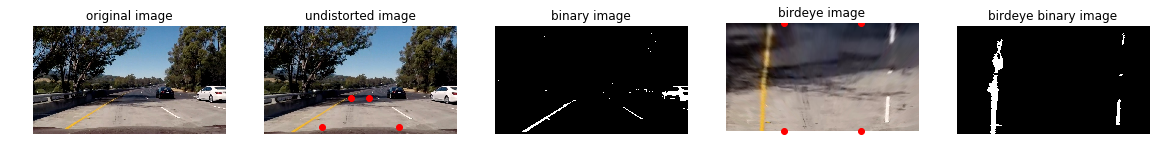

CPU times: user 568 ms, sys: 228 ms, total: 796 ms
Wall time: 514 ms


In [10]:
%%time
src_x = [581, 699, 896, 384]
src_y = [477, 477, 675, 675]

dst_x = [384, 896, 896, 384]
dst_y = [0, 0, 720, 720]

img = mpimg.imread(image)
undistored_img = undistort(img, mtx, dist)
binary_threshold = color_thresh(undistored_img)
warped_img = perspect_tf(undistored_img, M)
binary_warped = perspect_tf(binary_threshold, M)
plt.figure(figsize=[20, 5])
plt.subplot(1, 5, 1)
plt.axis('off')
plt.title('original image')
plt.imshow(img)
plt.subplot(1, 5, 2)
plt.axis('off')
plt.title('undistorted image')
plt.imshow(undistored_img)
plt.plot(src_x, src_y, 'ro')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.title('binary image')
plt.imshow(binary_threshold, cmap='gray')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.title('birdeye image')
plt.imshow(warped_img, cmap='gray')
plt.plot(dst_x, dst_y, 'ro')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.title('birdeye binary image')
plt.imshow(binary_warped, cmap='gray')
plt.show()

### Sliding window search

(720, 0)

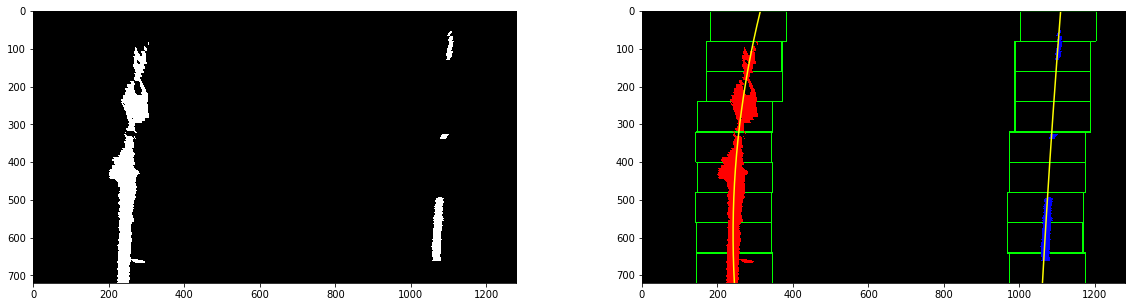

In [11]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
plt.imshow(binary_warped, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Margin search

(720, 0)

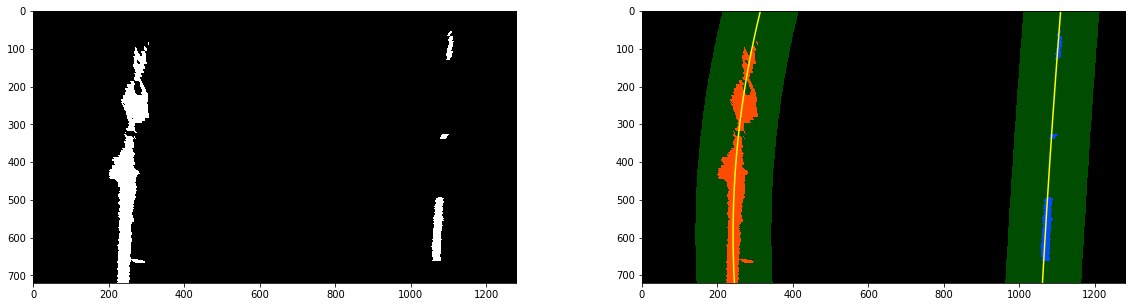

In [12]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
plt.imshow(binary_warped, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Repeat the calculation of radius of curvature after correcting for scale in x and y

In [13]:
y_eval = np.max(ploty)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
#calculate offset
midpoint = np.int(img.shape[1]/2)
middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
offset = (midpoint - middle_of_lane) * xm_per_pix
print('offset = ', offset)

794.246348956 m 10234.6239389 m
offset =  -0.0703861055477


### Visualize the result

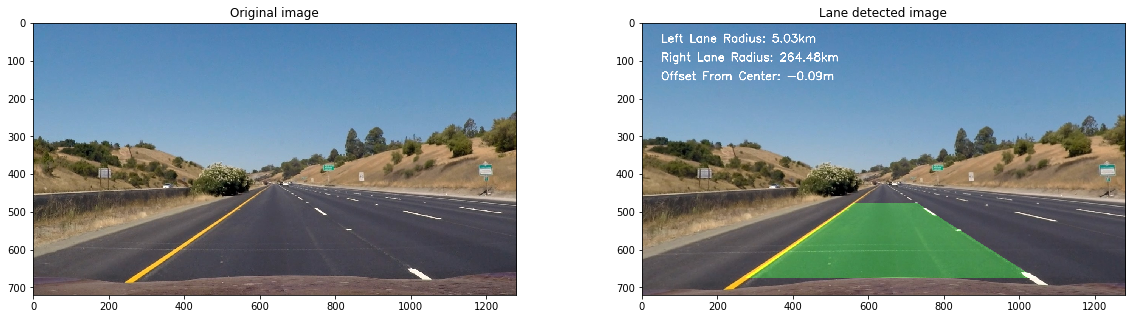

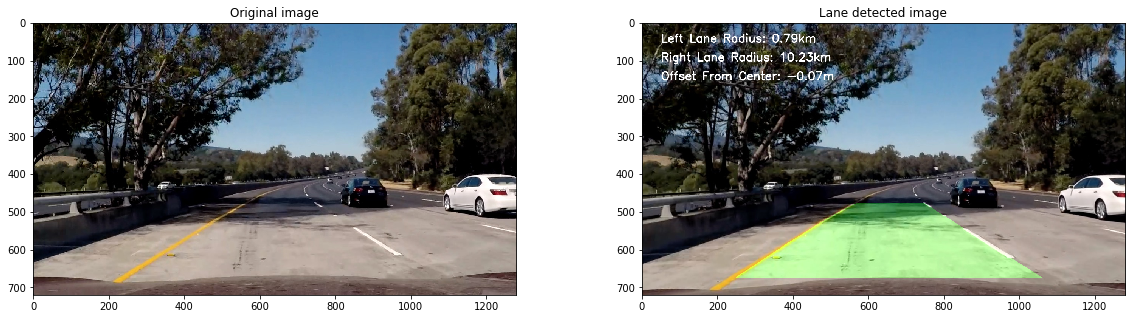

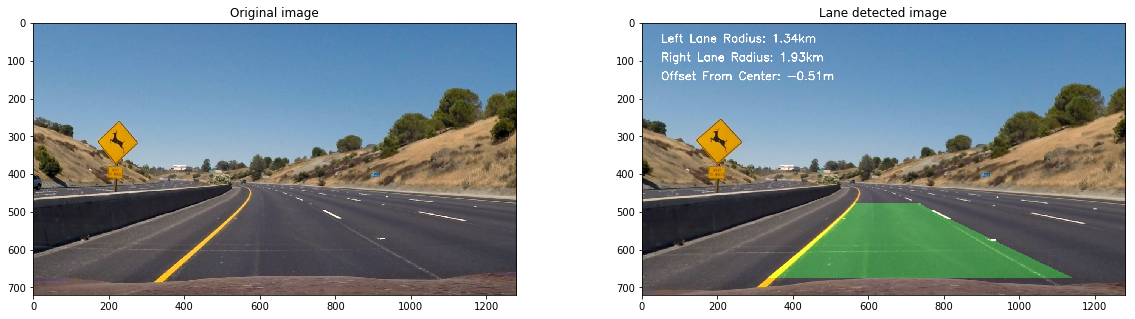

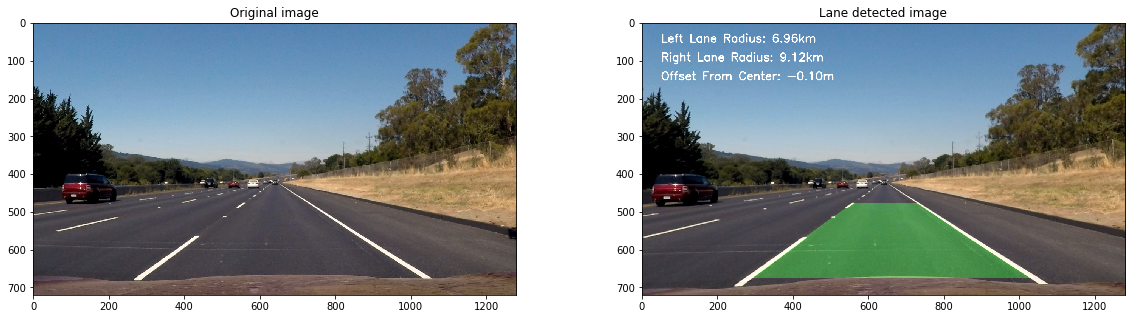

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
for image in test_images:
    img = mpimg.imread(image)
    result = pipeline(img, mtx, dist, M, Minv)
    plt.figure(figsize=[20, 5])
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title('Lane detected image')

In [3]:
def lane_detect(img):
    result = pipeline(img, mtx, dist, M, Minv)
    return result

In [4]:
lane_detect_output = 'output_videos/project_video_out.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
lane_detect_clip = clip1.fl_image(lane_detect)
%time lane_detect_clip.write_videofile(lane_detect_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|█████████▉| 1260/1261 [01:40<00:00, 13.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

CPU times: user 1min 48s, sys: 1.82 s, total: 1min 50s
Wall time: 1min 41s
